# Imports

In [41]:
%pip install tensorflow
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [42]:
import numpy as np
from sklearn.preprocessing import StandardScaler

def preprocess_data(df, label_col="label"):
    """
    Preprocess the DataFrame:
    - Separate labels from features.
    - Replace inf/-inf with NaN, fill NaNs with 0.
    - Remove columns with zero variance.
    - Scale features using StandardScaler.
    """
    y = df[label_col].values
    X = df.drop(columns=[label_col]).select_dtypes(include=[np.number])  # Keep numeric features

    # Handle NaN and Inf values
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

    # Remove zero-variance features
    X = X.loc[:, X.var(axis=0) != 0]

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled



In [43]:
# Load features and labels
features = np.load('../feature_extraction_smooth/image_features.npy')  # shape: (num_images, 500)
labels = np.load('../feature_extraction_smooth/image_labels.npy')        # shape: (num_images,)






# # Normalize the features with StandardScaler
# scaler = StandardScaler()
# features = scaler.fit_transform(features)

# features= preprocess_data(features)

# Assuming labels are integers from 0 to (num_categories-1).
num_classes = len(np.unique(labels))

# Convert labels to one-hot encoding
labels_categorical = to_categorical(labels, num_classes=num_classes)

In [44]:
# Split into training and test sets (e.g., 80-20 split)
X_train, X_test, y_train, y_test = train_test_split(features, labels_categorical, test_size=0.2, stratify=labels, random_state=42)


In [47]:
from sklearn.mixture import GaussianMixture

# Determine the number of components based on unique labels
n_components = num_classes

# Apply GMM
gmm = GaussianMixture(n_components=n_components, random_state=42, max_iter=100, verbose=2)
gmm.fit(X_train)

# Print convergence status
print(f"Number of Components: {n_components}")
print(f"GMM Converged: {gmm.converged_}")

# Assign GMM cluster labels
# gmm_labels_train = gmm.predict(X_train)
# gmm_labels_test = gmm.predict(X_test)

gmm_labels_test = y_test
gmm_labels_train = y_train


Initialization 0
  Iteration 10	 time lapse 8.18041s	 ll change 0.02686
Initialization converged. time lapse 13.05439s	 lower bound 2961.97193.
Number of Components: 15
GMM Converged: True


Training KNN: 100%|██████████| 30/30 [00:00<00:00, 32.08k-value/s]


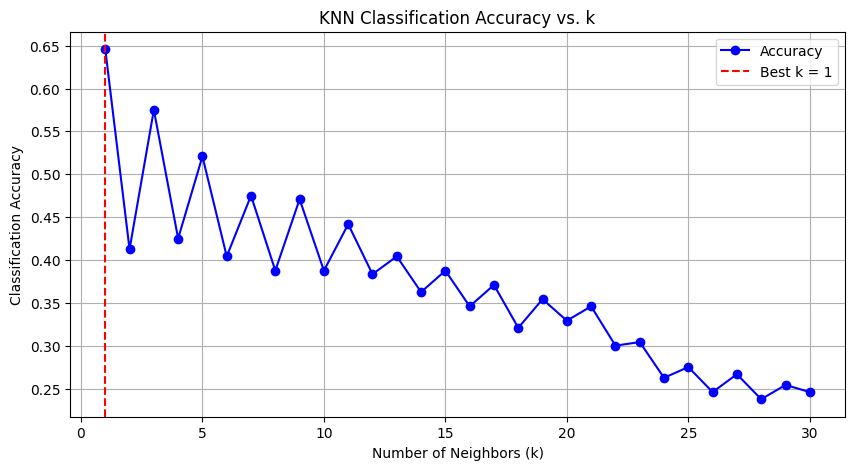

Best k: 1, Best Accuracy: 0.65


In [48]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Test k values from 1 to 30
k_values = range(1, 31)
accuracies = []

# Train KNN for different k values
with tqdm(total=len(k_values), desc="Training KNN", unit="k-value") as pbar:
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, gmm_labels_train)
        y_pred = knn.predict(X_test)
        acc = accuracy_score(gmm_labels_test, y_pred)
        accuracies.append(acc)
        pbar.update(1)

# Find the best k
best_k = k_values[np.argmax(accuracies)]
best_accuracy = max(accuracies)

# Plot accuracy vs k
plt.figure(figsize=(10, 5))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='b', label="Accuracy")
plt.axvline(best_k, color='r', linestyle='--', label=f'Best k = {best_k}')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Classification Accuracy")
plt.title("KNN Classification Accuracy vs. k")
plt.legend()
plt.grid()
plt.show()

print(f"Best k: {best_k}, Best Accuracy: {best_accuracy:.2f}")


In [52]:
k_values = range(1, 31)
accuracies_real = []

with tqdm(total=len(k_values), desc="Evaluating KNN (Real Labels)", unit="k-value") as pbar:
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, gmm_labels_train)
        gmm_pred_test = knn.predict(X_test)

        # Remap GMM labels to original labels
        label_mapping = {}
        for gmm_label in np.unique(gmm_labels_train):
            indices = np.where(gmm_labels_train == gmm_label)[0]
            original_labels_subset = labels[indices]
            most_common_label = np.bincount(original_labels_subset).argmax()
            label_mapping[gmm_label] = most_common_label

        # Convert GMM predictions to original labels
        predicted_labels = np.array([label_mapping[label] for label in list(gmm_pred_test)])
        actual_labels_eval = np.argmax(y_test, axis=1)
        acc = accuracy_score(actual_labels_eval, predicted_labels)
        accuracies_real.append(acc)

        pbar.update(1)

# Find best k based on actual label accuracy
best_k_real = k_values[np.argmax(accuracies_real)]
best_accuracy_real = max(accuracies_real)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(k_values, accuracies_real, marker='o', linestyle='-', color='g', label="Real Label Accuracy")
plt.axvline(best_k_real, color='r', linestyle='--', label=f'Best k = {best_k_real}')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy (Original Labels)")
plt.title("KNN Accuracy vs. k (Compared with Original Labels)")
plt.legend()
plt.grid()
plt.show()

print(f"Best k (Real Labels): {best_k_real}, Best Accuracy (Real Labels): {best_accuracy_real:.2f}")


Evaluating KNN (Real Labels):   0%|          | 0/30 [00:00<?, ?k-value/s]


TypeError: unhashable type: 'numpy.ndarray'

In [54]:
# Train KNN with the best k
best_k=best_k_real
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, gmm_labels_train)

# Predict on train and test data
y_pred_train = knn.predict(X_train)
y_pred_test = knn.predict(X_test)

# Compute accuracy
accuracy_train = accuracy_score(gmm_labels_train, y_pred_train)
accuracy_test = accuracy_score(gmm_labels_test, y_pred_test)

print(f"Train Accuracy: {accuracy_train:.2f}")
print(f"Test Accuracy: {accuracy_test:.2f}")


Train Accuracy: 1.00
Test Accuracy: 0.65


In [55]:
#print classification report
from sklearn.metrics import classification_report
print("Classification Report (Train):")
print(classification_report(gmm_labels_train, y_pred_train, target_names=[str(i) for i in range(num_classes)]))
print("Classification Report (Test):")
print(classification_report(gmm_labels_test, y_pred_test, target_names=[str(i) for i in range(num_classes)]))


Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        64
           1       1.00      1.00      1.00        64
           2       1.00      1.00      1.00        64
           3       1.00      1.00      1.00        64
           4       1.00      1.00      1.00        64
           5       1.00      1.00      1.00        64
           6       1.00      1.00      1.00        64
           7       1.00      1.00      1.00        64
           8       1.00      1.00      1.00        64
           9       1.00      1.00      1.00        64
          10       1.00      1.00      1.00        64
          11       1.00      1.00      1.00        64
          12       1.00      1.00      1.00        64
          13       1.00      1.00      1.00        64
          14       1.00      1.00      1.00        64

   micro avg       1.00      1.00      1.00       960
   macro avg       1.00      1.00      1.00      

In [63]:
# Convert one-hot encoded labels back to their original class indices
actual_labels = np.argmax(y_test, axis=1)

# Map GMM predicted labels back to original labels
predicted_labels = np.array([label_mapping[label] for label in y_test])

# Print actual vs predicted labels
for actual, predicted in zip(actual_labels, predicted_labels):
    print(f"Actual: {actual}, Predicted: {predicted}")

# Show the name of the class
# Class-wise accuracy
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(num_classes)], yticklabels=[str(i) for i in range(num_classes)])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



TypeError: unhashable type: 'numpy.ndarray'

In [57]:
from joblib import dump, load

# Save the trained model to a file
dump(knn, 'knn_model_smooth.joblib')

# Load the trained model from the file
loaded_knn = load('knn_model_smooth.joblib')

# Predict using the loaded model
y_pred_loaded_train = loaded_knn.predict(X_train)
accuracy_score_loaded_train = accuracy_score(gmm_labels_train, y_pred_loaded_train)
print(f"Loaded Model Train Accuracy: {accuracy_score_loaded_train:.2f}")


Loaded Model Train Accuracy: 1.00


In [58]:
print(labels)
print("---")
print(gmm_labels_train)

[ 0  0  0 ... 14 14 14]
---
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [59]:
#y_pred is the predicted labels from the KNN model in gmm_labels_test
#i need to convert the predicted labels back to the original labels
# Create a mapping from GMM labels to original labels
label_mapping = {}
for gmm_label in np.unique(gmm_labels_train):
    # Get the indices of the samples that belong to this GMM label
    indices = np.where(gmm_labels_train == gmm_label)[0]
    
    # Get the original labels for these samples
    original_labels = labels[indices]
    
    # Find the most common original label for this GMM label
    most_common_label = np.bincount(original_labels).argmax()
    
    # Map the GMM label to the most common original label
    label_mapping[gmm_label] = most_common_label

# Convert GMM labels to original labels using the mapping
predicted_labels = np.array([label_mapping[label] for label in gmm_labels_test])
print("Predicted labels:")
print(predicted_labels)

TypeError: unhashable type: 'numpy.ndarray'

In [ ]:
actual_labels = np.array([label_mapping[label] for label in actual_labels])

In [ ]:
real_accuracy = accuracy_score(actual_labels, predicted_labels)

In [ ]:
print(f"Real Test Accuracy: {real_accuracy:.2f}")

Real Test Accuracy: 0.11
